In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [47]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
import math
import numpy as np
import collections
from numpy import linalg as la
import time
import json
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import smart_open
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import pandas as pd

# Part-1) Tweets pre-processings

In [3]:
"""
This dataset consists only of one line where all the 2399 tweets by the WHO twitter account. 
We use the json python library to load this text as a dictionary since the dataset is stored 
in JSON format. 
"""
docs_path = 'dataset_tweets_WHO.txt'
with open(docs_path) as fp:
    lines = fp.readline()
tweets = json.loads(lines)

In [4]:
print("First tweet structure:")
tweets['0']

First tweet structure:


{'created_at': 'Wed Oct 13 09:15:58 +0000 2021',
 'id': 1448215930178310144,
 'id_str': '1448215930178310144',
 'full_text': "It's International Day for Disaster Risk Reduction\n\n#OpenWHO has launched a multi-tiered core curriculum to help equip you with the competencies needed to work within public health emergency response.\n\nStart learning today &amp; be #Ready4Response:\n👉 https://t.co/hBFFOF0xKL https://t.co/fgZY22RWuS",
 'truncated': False,
 'display_text_range': [0, 274],
 'entities': {'hashtags': [{'text': 'OpenWHO', 'indices': [52, 60]},
   {'text': 'Ready4Response', 'indices': [232, 247]}],
  'symbols': [],
  'user_mentions': [],
  'urls': [{'url': 'https://t.co/hBFFOF0xKL',
    'expanded_url': 'https://bit.ly/3wCa0Dr',
    'display_url': 'bit.ly/3wCa0Dr',
    'indices': [251, 274]}],
  'media': [{'id': 1448215398814560259,
    'id_str': '1448215398814560259',
    'indices': [275, 298],
    'media_url': 'http://pbs.twimg.com/ext_tw_video_thumb/1448215398814560259/pu/img/0CO

In [5]:
tweets['0'].keys()

dict_keys(['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'lang'])

In [6]:
print("First three full text tweets:\n")
for i in range(3):
    print("Tweet number",i+1,":\n")
    print(tweets[str(i)]["full_text"])
    print("\n")
    

First three full text tweets:

Tweet number 1 :

It's International Day for Disaster Risk Reduction

#OpenWHO has launched a multi-tiered core curriculum to help equip you with the competencies needed to work within public health emergency response.

Start learning today &amp; be #Ready4Response:
👉 https://t.co/hBFFOF0xKL https://t.co/fgZY22RWuS


Tweet number 2 :

#COVID19 has shown how health emergencies and disasters affect entire communities – especially those with weak health systems, and vulnerable populations like migrants, indigenous peoples, and those living in fragile humanitarian conditions. https://t.co/jpUQpnu0V1


Tweet number 3 :

It's International Day for Disaster Risk Reduction
 
To better respond to emergencies countries must:
✅ invest in health care systems
✅ achieve gender equity
✅ protect marginalised groups
✅ ensure ready &amp; equitable access to supplies
 
A strong &amp; resilient health system is 🔑 https://t.co/5NALyjIymp




In [7]:
def process_tweet(line):
    """
    Pre-process the tweet text removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.
    
    Argument:
    line -- string (text) to be pre-processed
    
    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    ## START CODE
    line = line.lower() ## Transform in lowercase
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    line = tokenizer.tokenize(line)
    line = [word for word in line if word not in stop_words]  ##eliminate the stopwords (HINT: use List Comprehension)
    line = [stemmer.stem(word) for word in line] ## perform stemming (HINT: use List Comprehension)
    i = 0
    for word in line:
        if word[0:4] == 'http':
            line = line[:i]
        i+=1
    ## END CODE
    return line

In [8]:
"""
Here for every tweet we extract the 'full_text' variable since we will only 
search inside the text of each tweet. Thus, we pre-process each tweet and 
store it in a new dictionary called proc_tweets for later use
"""
proc_tweets = {}
for tweet_id, tweet in zip(tweets.keys(),tweets.values()):
    proc_tweets[int(tweet_id)] = process_tweet(tweet['full_text'])

In [9]:
print("First five processed tweets\n")
for i in range(3):
    print(proc_tweets[i])
    print("\n")
    

First five processed tweets

['intern', 'day', 'disast', 'risk', 'reduct', 'openwho', 'launch', 'multi', 'tier', 'core', 'curriculum', 'help', 'equip', 'compet', 'need', 'work', 'within', 'public', 'health', 'emerg', 'respons', 'start', 'learn', 'today', 'amp', 'ready4respons']


['covid19', 'shown', 'health', 'emerg', 'disast', 'affect', 'entir', 'commun', 'especi', 'weak', 'health', 'system', 'vulner', 'popul', 'like', 'migrant', 'indigen', 'peopl', 'live', 'fragil', 'humanitarian', 'condit']


['intern', 'day', 'disast', 'risk', 'reduct', 'better', 'respond', 'emerg', 'countri', 'must', 'invest', 'health', 'care', 'system', 'achiev', 'gender', 'equiti', 'protect', 'marginalis', 'group', 'ensur', 'readi', 'amp', 'equit', 'access', 'suppli', 'strong', 'amp', 'resili', 'health', 'system']




Lab 2:

INDEXING:
1. Create inverted index
2. Make a proposal of 5 queries that will be used to evaluate our search engine
3. Apply a TF-IDF ranking to your results

EVALUATION:
1. Set the ground truth for each document and queryy (binary way)
2. Evaluate the algorithm with:
    2.1 Precision @K
    2.2 Average Precision @K 
    2.3 Mean Average Precision
    2.4 Mean Reciprocal Rank
    2.5 Normalizewd Discounted Cummulative Gain
3. Choose one vector rpresentation (TF-IDF or word2vec)

In [10]:
def get_tweet_info(tweet):
    Tweet = tweet['full_text']
    Username = tweet['user']['name']
    Date = tweet['created_at']
    #Hashtags = tweet['entities']['hashtags']['text']

    Hashtags = []
    hashtags_list = tweet['entities']['hashtags']
    for hashtag in hashtags_list:
        Hashtags.append(hashtag['text'])

    Likes = tweet['favorite_count']
    Retweets = tweet['retweet_count']
    Url = f"https://twitter.com/{tweet['user']['screen_name']}/status/{tweet['id_str']}"
    info = [Tweet, Username, Date, Hashtags, Likes, Retweets, Url]
    return info

In [11]:
def create_index(tweets):
    """
    Generates the index from our database to perform queries from
    
    Argument:
    tweets -- collection of tweets
    
    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of documents where these keys appears in (and the positions) as values.
    """
    index = {}
    id_index = {}
    tf = {}
    df = defaultdict(int)
    idf = defaultdict(float)
    numDocuments = len(tweets)
    for i in range(numDocuments):
        tweet = tweets[str(i)]
        terms = process_tweet(tweet['full_text']) #get tweet text
        info = get_tweet_info(tweet) # get "document" info
        id_tweet = tweet['id']
        id_index[id_tweet]=info
        
        
        for term in terms: # terms contains page_title + page_text. Loop over all terms
            try:
                # if the term is already in the index for the current page (current_page_index)
                # append the position to the corresponding list
                index[term].append(id_tweet)  
                
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                index[term]= [id_tweet]#'I' indicates unsigned int (int in Python)
            
        norm=0
        for term,ids in index.items():
            norm += len(ids)**2
        norm = math.sqrt(norm)
        
        for term,ids in index.items():
            if term in tf:
                tf[term][id_tweet] = np.round(len(ids)/norm,4)
            else:
                tf[term] = {id_tweet:np.round(len(ids)/norm,4)}
            df[term] += 1
        
        for term in index:
            idf[term] = np.round(np.log(float(numDocuments/df[term])),4)
        
    return index, tf,df,idf,id_index


In [12]:
start_time = time.time()
index, tf,df,idf,id_index = create_index(tweets)
print("Total time to create the index: {} seconds".format(np.round(time.time() - start_time, 2)))

Total time to create the index: 189.57 seconds


In [13]:
def search(query, index):
    query = process_tweet(query)
    first = True
    docs = {}
    for term in query:
        try:
            list_docs = index[term]
            if first:
                docs = set(list_docs)
                first = False
            else:
                docs &= set(list_docs)
            
        except:
            break
    docs=list(docs)
    return docs           

In [14]:
# def search(query, index):
#     query = process_tweet(query)
    

In [15]:
print("Insert your query:\n")
query = input()
docs = search(query,index)

print("Top 10 results:\n")
for d_id in docs[:10]:
    print(f"{id_index[d_id]}\n")

Insert your query:

covid vaccine
Top 10 results:

['RT @WHOAFRO: 📺 LIVE: @WHOAFRO media briefing on the #COVID19 pandemic &amp; the global 10% COVID-19 vaccination milestones reached by countries…', 'World Health Organization (WHO)', 'Thu Sep 30 10:07:43 +0000 2021', ['COVID19'], 0, 27, 'https://twitter.com/WHO/status/1443517908072730624']

["RT @WHOAFRO: Join tomorrow's media briefing on the #COVID19 pandemic &amp; the global 10% COVID-19 vaccination milestones reached by countries…", 'World Health Organization (WHO)', 'Wed Sep 29 19:01:27 +0000 2021', ['COVID19'], 0, 21, 'https://twitter.com/WHO/status/1443289841698025473']

['RT @WHOPhilippines: Vaccines can’t stop #COVID19 alone, but by doing it all we can help protect ourselves and our loved ones against COVID-…', 'World Health Organization (WHO)', 'Mon Oct 11 04:39:10 +0000 2021', ['COVID19'], 0, 71, 'https://twitter.com/WHO/status/1447421491428143106']

['Q&amp;A #AskWHO on COVID-19 vaccines effectiveness https://t.co/FEdfOREhj

In [16]:
def rank_documents(terms, docs, index, idf, tf, title_index):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title
    
    Returns:
    Print the list of ranked documents
    """

    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query. 
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    #HINT: use when computing tf for query_vector

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex]=query_terms_count[term]/query_norm * idf[term] 

        # Generate doc_vectors for matching docs
        for doc in index[term]:
            # Example of [doc_index, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....

            #tf[term][0] will contain the tf of the term "term" in the doc 26            
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc] * idf[term]  # TODO: check if multiply for idf

    # Calculate the score of each doc 
    # compute the cosine similarity between queyVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine similarity
    # see np.dot
    
    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    #print document titles instead if document id's
    #result_docs=[ title_index[x] for x in result_docs ]
    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        if not query:
            return None
        docs = search_tf_idf(query, index)
    #print ('\n'.join(result_docs), '\n')
    return result_docs, doc_scores

In [17]:
def search_tf_idf(query, index):
    """
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query = process_tweet(query)
    docs = set()
    first = True
    if not query:
        return None
    for term in query:
        try:
            list_docs = index[term]
            if first:
                docs = set(list_docs)
                first = False
            else:
                docs &= set(list_docs)
        except:
            break
            
    docs = list(docs)
    ranked_docs, doc_scores = rank_documents(query, docs, index, idf, tf, id_index)
    
    return ranked_docs, doc_scores

In [18]:
print("Insert your query (i.e.: Computer Science):\n")
query = input()
ranked_docs, doc_scores = search_tf_idf(query, index)
top = 10
if ranked_docs:
    print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
    for d_id in ranked_docs[:top]:
        print(f"{id_index[d_id]}\n")

Insert your query (i.e.: Computer Science):

covid vaccine

Top 10 results out of 13 for the searched query:

["RT @WHOAFRO: Join tomorrow's media briefing on the #COVID19 pandemic &amp; the global 10% COVID-19 vaccination milestones reached by countries…", 'World Health Organization (WHO)', 'Wed Sep 29 19:01:27 +0000 2021', ['COVID19'], 0, 21, 'https://twitter.com/WHO/status/1443289841698025473']

['RT @WHOAFRO: 📺 LIVE: @WHOAFRO media briefing on the #COVID19 pandemic &amp; the global 10% COVID-19 vaccination milestones reached by countries…', 'World Health Organization (WHO)', 'Thu Sep 30 10:07:43 +0000 2021', ['COVID19'], 0, 27, 'https://twitter.com/WHO/status/1443517908072730624']

['Q&amp;A #AskWHO on COVID-19 vaccines effectiveness https://t.co/FEdfOREhjn', 'World Health Organization (WHO)', 'Wed Jun 30 16:12:43 +0000 2021', ['AskWHO'], 219, 85, 'https://twitter.com/WHO/status/1410270080873598979']

['The heads of the four organizations discussed the urgency of increasing supplie

# 3.1

In [48]:
print("Evaluation:\n")
print("Please, assing value 0 for non relevant tweets and 1 for relevant tweets:\n")
top = 10
y = []
docs_id = []
predicted_relevance = []
q_id = [0]*top #We only will manage one query
i = 0
for d_id in ranked_docs[:top]:
    print(f"{id_index[d_id]}\n")
    predicted_relevance.append(doc_scores[i][0])
    docs_id.append(d_id)
    punctuation = int(input("Punctuation for this tweet (0 or 1):"))
    print("\n")
    y.append(punctuation) 
    i+=1
data = {'q_id':q_id,'doc_id': docs_id, 'predicted_relevance': predicted_relevance,'bin_y_true':y}
search_results = pd.DataFrame(data)
search_results

Evaluation:

Please, assing value 0 for non relevant tweets and 1 for relevant tweets:

["RT @WHOAFRO: Join tomorrow's media briefing on the #COVID19 pandemic &amp; the global 10% COVID-19 vaccination milestones reached by countries…", 'World Health Organization (WHO)', 'Wed Sep 29 19:01:27 +0000 2021', ['COVID19'], 0, 21, 'https://twitter.com/WHO/status/1443289841698025473']

Punctuation for this tweet (0 or 1):1


['RT @WHOAFRO: 📺 LIVE: @WHOAFRO media briefing on the #COVID19 pandemic &amp; the global 10% COVID-19 vaccination milestones reached by countries…', 'World Health Organization (WHO)', 'Thu Sep 30 10:07:43 +0000 2021', ['COVID19'], 0, 27, 'https://twitter.com/WHO/status/1443517908072730624']

Punctuation for this tweet (0 or 1):1


['Q&amp;A #AskWHO on COVID-19 vaccines effectiveness https://t.co/FEdfOREhjn', 'World Health Organization (WHO)', 'Wed Jun 30 16:12:43 +0000 2021', ['AskWHO'], 219, 85, 'https://twitter.com/WHO/status/1410270080873598979']

Punctuation for this tw

q_id               doc_id  predicted_relevance  bin_y_true
0     0  1443289841698025473         3.645828e-07           1
1     0  1443517908072730624         3.568089e-07           1
2     0  1410270080873598979         2.900135e-07           1
3     0  1410328481335029765         2.882401e-07           0
4     0  1418205159188955137         2.836071e-07           0
5     0  1422146679051067400         2.818994e-07           1
6     0  1418229392514424836         2.815947e-07           1
7     0  1416433609091653633         2.805192e-07           0
8     0  1433469315710341130         2.774539e-07           0
9     0  1434790971632336906         2.773414e-07           1

# 3.2

In [21]:
def precision_at_k(y_true, y_score, k=10):
    '''    
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.
    
    Returns
    -------
    precision @k : float
    
    '''    
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order)[:k]
    relevant = np.sum(y_true)
    
    return relevant/k

In [22]:
def avg_precision_at_k(y_true, y_score, k=10):
    
    '''
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.
    
    Returns
    -------
    average precision @k : float
    '''
    
    gtp = np.sum(y_true == 1)
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])           

    ## if all docs are not relevant
    if gtp==0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(y_true)):
        if y_true[i] == 1:
            n_relevant_at_i += 1
            prec_at_i += n_relevant_at_i/(i + 1)
            
    return prec_at_i/gtp

In [23]:
def map_at_k(search_res, k=10):
    '''
    Parameters
    ----------
    search_res: search results dataset containing:
        q_id: query id.
        doc_id: document id.
        predicted_relevance: relevance predicted through LightGBM.
        y_true: actual score of the document for the query (ground truth).
    
    Returns
    -------
    mean average precision @k : float
    '''
    avp = []
    for q in search_res['q_id'].unique(): #loop over all query id
        curr_data = search_res[search_res['q_id'] == q]  # select data for current query
        avp.append(avg_precision_at_k(np.array(curr_data['bin_y_true']), np.array(curr_data['predicted_relevance']), k)) #append average precision for current query
    return np.sum(avp)/len(avp)#, avp # return mean average precision

In [24]:
def rr_at_k(y_true, y_score, k=10):
    '''
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.
    
    Returns
    -------
    Reciprocal Rank for qurrent query
    '''

    order = np.argsort(y_score)[::-1] # get the list of indexes of the predicted score sorted in descending order.
    y_true = np.take(y_true, order[:k]) # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.

    if np.sum(y_true) == 0: # if there are not relevant doument return 0
        return 0
    return 1/(np.argmax(y_true == 1) + 1) # hint: to get the position of the first relevant document use "np.argmax"

In [25]:
def dcg_at_k(y_true, y_score,  k=10):
    order = np.argsort(y_score)[::-1] # get the list of indexes of the predicted score sorted in descending order.
    y_true = np.take(y_true, order[:k]) # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    gain = (2**y_true) - 1 # Compute gain (use formula 7 above)
    discounts = np.log2(np.arange(len(y_true)) + 2) # Compute denominator
    return np.sum(gain / discounts) #return dcg@k


def ndcg_at_k(y_true, y_score, k=10):    
    dcg_max = dcg_at_k(y_true, y_true, k) # Ideal dcg
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(y_true, y_score, k)/dcg_max,4)  # return ndcg@k

In [49]:
current_query = 0
current_query_res = search_results[search_results["q_id"] == current_query] 
k = 10
print("==> Precision@{}: {}\n".format(k,precision_at_k(current_query_res["bin_y_true"], current_query_res["predicted_relevance"], k)))
print("==> AveragePrecision@{}: {}\n".format(k,avg_precision_at_k(np.array(current_query_res["bin_y_true"]), np.array(current_query_res["predicted_relevance"]), 150)))
print("==> MeanAveragePrecision@{}: {}\n".format(k,map_at_k(search_results, 10)))
mrr = {}
for k in [3,5,10]:
    RRs = []
    for q in search_results['q_id'].unique(): # loop over all query ids
        labels = np.array(search_results[search_results['q_id'] == q] ['bin_y_true']) # get labels for current query
        scores = np.array(search_results[search_results['q_id'] == q] ['predicted_relevance']) # get predicted score for current query
        RRs.append(rr_at_k(labels, scores, k)) # append RR for current query
    mrr[k] = np.round(float(sum(RRs)/len(RRs)) ,4) # Mean RR at current k
print("==> MeanReciprocalRank: {}\n".format(mrr[k]))
labels = np.array(search_results[search_results['q_id'] == q_id]["bin_y_true"])
scores = np.array(search_results[search_results['q_id'] == q_id]["predicted_relevance"])
ndcg_k = np.round(ndcg_at_k(labels, scores, k),4)
print("==> NormalizedDiscountedCumulativeGain@{} for query with q_id={}: {}".format(k,current_query,ndcg_k))


==> Precision@10: 0.6

==> AveragePrecision@10: 0.83015873015873

==> MeanAveragePrecision@10: 0.83015873015873

==> MeanReciprocalRank: 1.0

==> NormalizedDiscountedCumulativeGain@10 for query with q_id=0: 0.941


# 3.3

In [26]:
words = [[word for word in index.keys()]]

word2vec = Word2Vec(words, min_count=1)

In [27]:
vocabulary = word2vec.wv.key_to_index
print(vocabulary)

{'interfer': 0, 'roadmap': 1, 'accord': 2, 'analysi': 3, 'trend': 4, 'preval': 5, 'speedi': 6, 'optim': 7, 'defeatmening': 8, 'bacteri': 9, 'tigray': 10, 'epidem': 11, '50': 12, 'elev': 13, 'kidney': 14, 'stiff': 15, 'neck': 16, 'sensit': 17, '1990': 18, '28': 19, '650': 20, 'doubl': 21, 'messeng': 22, 'viber': 23, 'discov': 24, 'latest': 25, 'lite': 26, 'freebas': 27, 'hot': 28, 'humid': 29, 'pathogen': 30, 'mosquito': 31, 'episod': 32, 'eye': 33, 'podcast': 34, '79': 35, 'hypertens': 36, 'light': 37, 'confus': 38, 'headach': 39, 'directli': 40, 'account': 41, 'choos': 42, 'interact': 43, 'fingertip': 44, 'ℹ': 45, 'alert': 46, 'via': 47, 'type': 48, 'hi': 49, 'belt': 50, 'stretch': 51, 'seneg': 52, 'west': 53, 'east': 54, 'exploit': 55, 'cardiovascular': 56, 'notif': 57, 'rash': 58, 'user': 59, 'seizur': 60, 'infant': 61, 'bulg': 62, 'fontanel': 63, 'droopi': 64, 'unrespons': 65, 'meningococcu': 66, 'pneumococcu': 67, 'bacteria': 68, 'haemophilu': 69, 'influenza': 70, 'seri': 71, 'moe

In [40]:
keys = ['covid','vaccine','economic']
keys = [process_tweet(word) for word in keys]
embedding_clusters = []
word_clusters = []

for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in word2vec.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(word2vec.wv[similar_word])
        
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [41]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=1000, random_state=32,verbose=1)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 90 samples in 0.000s...
[t-SNE] Computed neighbors for 90 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 90 / 90
[t-SNE] Mean sigma: 0.017625
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.788383
[t-SNE] KL divergence after 1000 iterations: 0.906929


In [42]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
C:\Users\David\anaconda3\lib\site-packages\mat

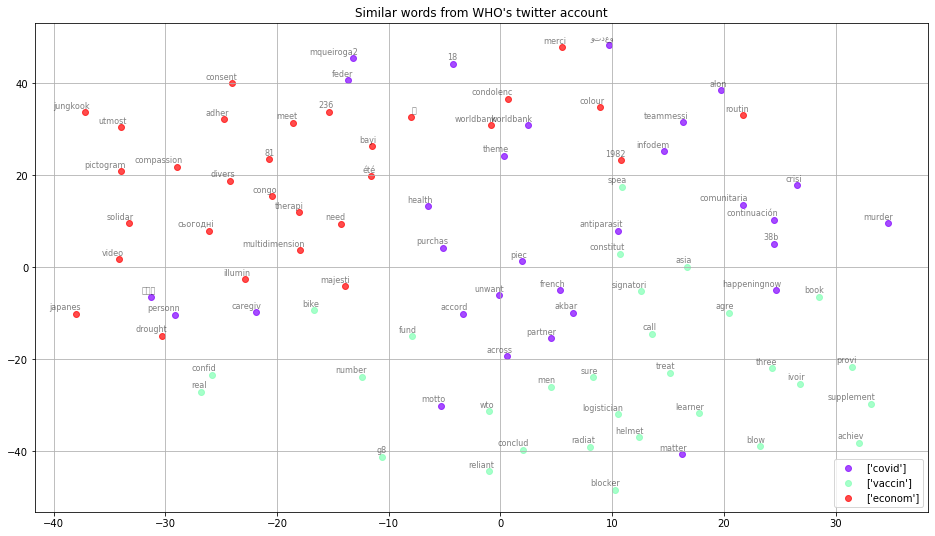

In [43]:
tsne_plot_similar_words("Similar words from WHO's twitter account", keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')